In [8]:
%%time
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket='your-bucket-name' # customize to your bucket

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest
CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 57.2 ms


In [9]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,32,32"
# we also need to specify the number of training samples in the training set
# for caltech it is 25000
num_training_samples = 25000
# specify the number of output classes (dogs vs cat)
num_classes = 2
# batch size for training
mini_batch_size =  128
# number of epochs
epochs = 6
# learning rate
learning_rate = 0.01
top_k=2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

In [10]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-dogvscat-notebook'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/dog-vs-cat/train/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/dog-vs-cat/validation/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))

print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-dogvscat-notebook-2018-03-06-06-59-18

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sm-demo-iad/dog-vs-cat/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.9 ms


In [11]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending statua
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [12]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


In [14]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="dogvscat"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

dogvscat
s3://sm-demo-iad/sagemaker-dogvscat-notebook/output/sagemaker-dogvscat-notebook-2018-03-06-06-59-18/output/model.tar.gz
arn:aws:sagemaker:us-east-1:460508756665:model/dogvscat
CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 369 ms


In [15]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-dogvscat-notebook-epc--2018-03-06-07-27-39
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:460508756665:endpoint-config/sagemaker-dogvscat-notebook-epc--2018-03-06-07-27-39


In [16]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-dogvscat-notebook-ep--2018-03-06-07-27-53
EndpointArn = arn:aws:sagemaker:us-east-1:460508756665:endpoint/sagemaker-dogvscat-notebook-ep--2018-03-06-07-27-53
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 199 ms


In [17]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [18]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

--2018-03-06 11:03:54--  https://s3.amazonaws.com/sm-demo-iad/dog-vs-cat/test/10019.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.50.90
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.50.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36877 (36K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  36.01K  --.-KB/s    in 0.002s  

2018-03-06 11:03:54 (15.7 MB/s) - ‘/tmp/test.jpg’ saved [36877/36877]



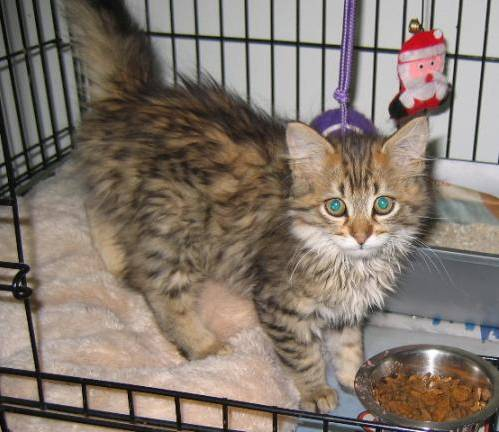

In [93]:
!wget -O /tmp/test.jpg https://s3.amazonaws.com/sm-demo-iad/dog-vs-cat/test/10019.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [94]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = [ 'cat', 'dog']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - cat, probability - 0.6736167073249817
